(c) Merten Stender, Hamburg University of Technology, Dynamics Group (www.tuhh.de/dyn), m.stender@tuhh.de

# III-B: Model selection for the univariate set-up
univariate modeling task: predict one factor from the absorption curves. Single-label (i.e. one feature dimension at a time) multi-class (not necessarily a binary) classification task.

### model selection:
5-fold cross-validation of each of the ML models $\mathcal{M}_{1,2}$ for each of the downsampling rates $n_{\mathrm{f}}$.

#### input
$\alpha (f)$ curve (possibly down-sampled, see *prepare_data* notebook)

#### output
one-hot encoded value $Y$ of a single factor $k$, each factor is treated seperately. There are factors that have only two class members (such as the mounting option: from below or from above), but there are other factors that have more than 2 classes. Depending on the number $m_k$ of classes, the task becomes a binary / multiclass classification task.

#### Please note
that we use random shuffling of the data, hence the results may slightly differ from the ones reported in Table III



#### import required packages and utilities

In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import shap as shap
import os
import shutil
import utils as utils

### define the complete modeling task as a function

such that we can call this one later on in a loop to do all the batch processing for all model and data combinations

ML hyperparameters: 
- #epochs = 50
- batch size = 64
- 5-fold cross validation

In [2]:
def do_univar_modeling(factor_name, n_sampling, model_name):
    
    """
    factor_name: state the factor you'd like to predict
    n_sampling: number of frequency points, i.e. the degree of dimensionality reduction
    model_name: choose the model architecture (baseline model, deep MLP or CNN)
    """
    
    cur_path = 'model_selection_results' 
    
    n_features = n_sampling
    factor = factor_name
    mod = model_name

    # load the corresponding data for the given sampling (generated through prepare_data, to be consistent for all models)
    filename = 'data_' + str(n_features) + '.pickle'

    # structure of the pickle file: [X_train, X_test, y_train, y_test, factor_names, f]
    data = pickle.load(open(filename, "rb" ))

    X_train = data[0]  # unzip the data list
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    factor_names = data[4]
    f = data[5]

    # extract the correct (univariate) one-hot encoded target vectors for the current factor
    y_train, class_names = utils.get_univariate_targets(y_train, quant=factor)  # training set labels
    y_test, class_names = utils.get_univariate_targets(y_test, quant=factor)    # test set labels

    # get the dimensions right for the model
    n_cv = len(X_train)              # number of cross-validation folds
    n_samples = X_train[0].shape[0]  # number of samples (observations) in the training set
    n_outputs = y_train[0].shape[1]  # number of outputs (i.e. output classes)

    # compute the expected value (i.e. the mean value of the outputs)
    E_train = np.mean(np.array(pd.concat(y_train[:])), axis = 0)
    E_test = np.mean(np.array(pd.concat(y_test[:])), axis = 0)
    print('expected values: ' + str(np.round(E_train,2))+ ' (training)') 
    print('expected values: ' + str(np.round(E_test,2))+ ' (test)') 

    # train the model. Thus is the single-label multiclass setting.
    model = utils.build_model(model_name=mod, n_features=n_features, n_outputs=n_outputs, multilabel_flag=False)

    # train and evaluate the model for the k-fold CV data sets
    test_acc =  []
    models = []
    histories = []

    for idx in range(n_cv): # iterate the CV folds and get the test set performance, the training history and the model

        # train model on data set [idx] and evaluate the test set performance
        model_, history_, test_acc_ = utils.train_evaluate_model(model, epochs=50, \
                                                                 batch_size=64, X_train=X_train[idx], X_test=X_test[idx], \
                                                                 y_train=np.array(y_train[idx]), y_test=np.array(y_test[idx]))

        # append score and history to global variables
        test_acc.append(test_acc_)
        histories.append(pd.DataFrame(history_.history))  # convert the dict to pandas DF first

        ## save the model to local h5 file
        #model.save('./' + cur_path + '/tf_model_' + str(idx) + '.h5')

    # compute statistics
    mean_acc = np.mean(test_acc)
    std_acc = np.std(test_acc)

    print('mean acc: ' + str(np.round(mean_acc, 2)))
    print('std acc: ' + str(np.round(std_acc,2))) 
    
    # save data to local .pickle file containing a dict
    sav_data = {'mean_acc':mean_acc, 'std_acc':std_acc, 'test_acc':test_acc, 'class_names':class_names, \
                'histories':histories, 'E_train':E_train, 'E_test':E_test}
    sav_str = factor_name + '-' + str(n_sampling) + '-' + model_name
    outfile = open('./' + cur_path + '/results-'+sav_str +'.pickle','wb')
    pickle.dump(sav_data,outfile)
    outfile.close()
    
    # plot the training history 
    plt.figure(figsize=(8, 2), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(1,2,1)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(sav_str)
    for i in range(n_cv):
        plt.plot(histories[i]['loss'], color='k')
        plt.plot(histories[i]['val_loss'], color='r')
    plt.legend('training', 'validation')

    plt.subplot(1,2,2)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim([-0.1, 1.1])
    plt.title('mean: ' + str(np.round(mean_acc, 2)) + ' , std: ' + str(np.round(std_acc, 2)))
    for i in range(n_cv):
        plt.plot(histories[i]['val_accuracy'], color='k')
        plt.plot(histories[i]['val_accuracy'], color='r')

    plt.savefig('./' + cur_path + '/'+sav_str +'training_process.png')
    plt.show()
    plt.close()
    

### evaluate the model performance for a grid of parameter combinations

This can become combinatorially complex as we consider a larger number of factors, three different data sets and two different models. You'll need to be patient :)


[WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'model_selection_results' already existing
running 1/30 :thickness, 1960, baseline
expected values: [0.25 0.25 0.25 0.25] (training)
expected values: [0.25 0.25 0.25 0.25] (test)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1960)              3843560   
_________________________________________________________________
dense_1 (Dense)              (None, 980)               1921780   
_________________________________________________________________
dense_2 (Dense)              (None, 50)                49050     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 

Legend does not support 't' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
Legend does not support 'n' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


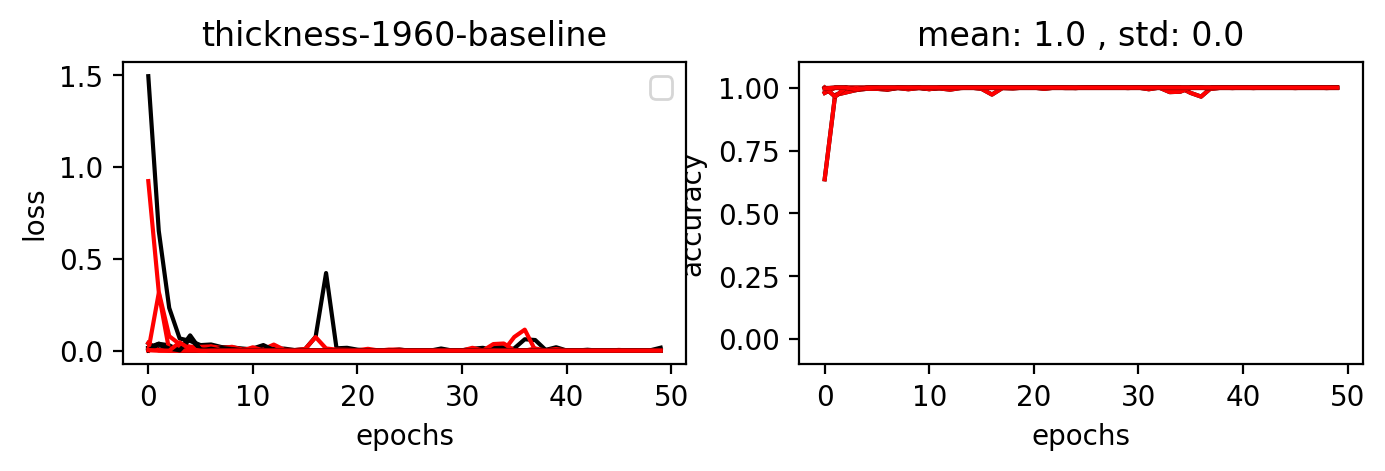

running 2/30 :thickness, 1960, deepmlp
expected values: [0.25 0.25 0.25 0.25] (training)
expected values: [0.25 0.25 0.25 0.25] (test)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1960)              3843560   
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 980)               1921780   
_________________________________________________________________
dropout_1 (Dropout)          (None, 980)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 490)               480690    
_________________________________________________________________
dropout_2 (Dropout)          (None, 490)           

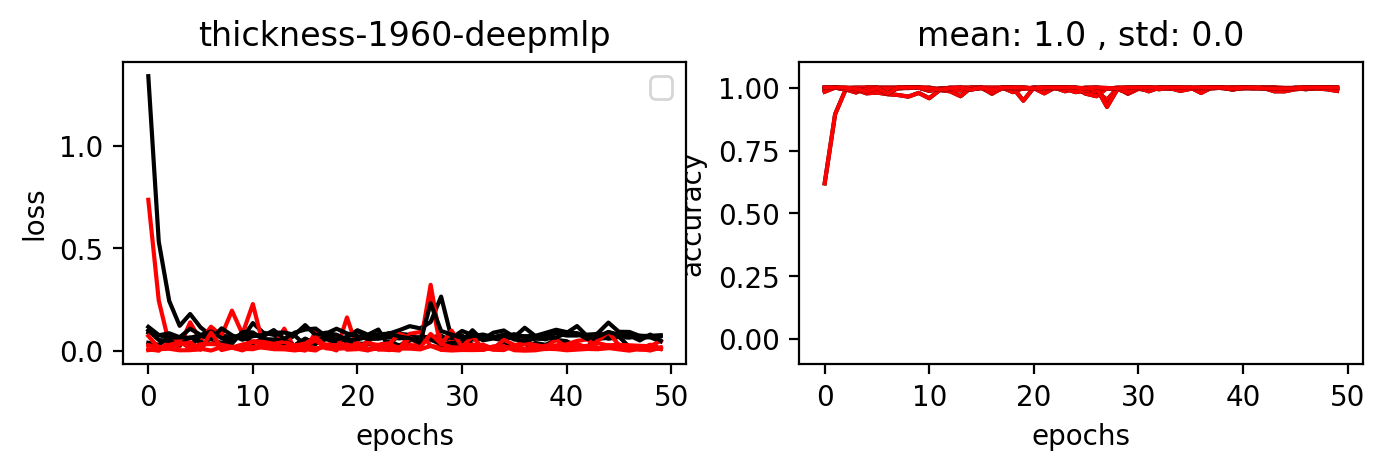

running 3/30 :thickness, 980, baseline
expected values: [0.25 0.25 0.25 0.25] (training)
expected values: [0.25 0.25 0.25 0.25] (test)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 980)               961380    
_________________________________________________________________
dense_14 (Dense)             (None, 490)               480690    
_________________________________________________________________
dense_15 (Dense)             (None, 50)                24550     
_________________________________________________________________
dense_16 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 104       
Total params: 1,467,999
Trainable params: 1,467,999
Non-trainable params: 0
_________________________________________

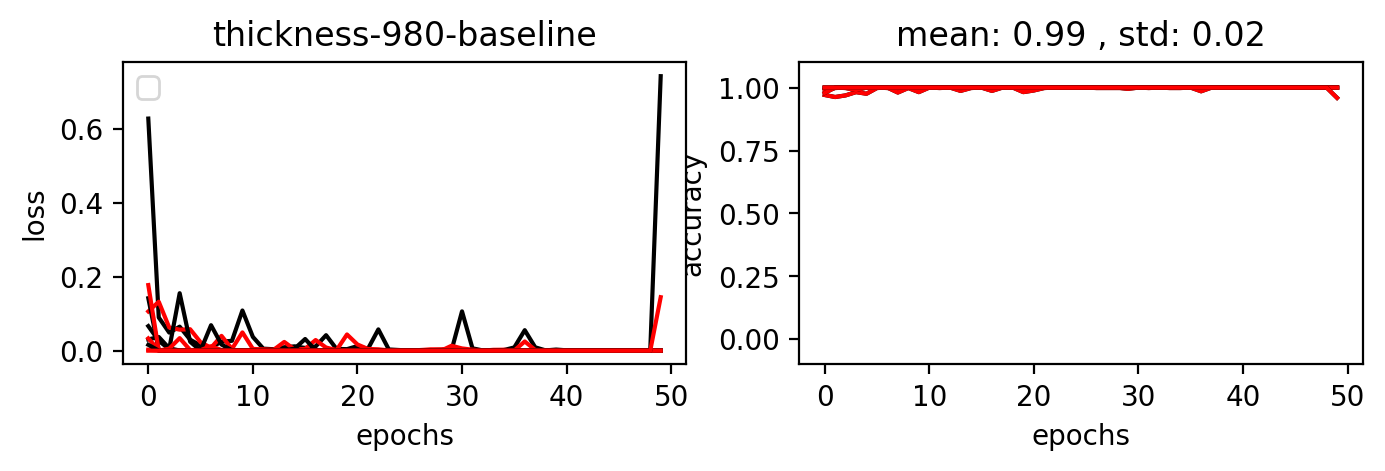

running 4/30 :thickness, 980, deepmlp
expected values: [0.25 0.25 0.25 0.25] (training)
expected values: [0.25 0.25 0.25 0.25] (test)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 980)               961380    
_________________________________________________________________
dropout_6 (Dropout)          (None, 980)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 490)               480690    
_________________________________________________________________
dropout_7 (Dropout)          (None, 490)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 245)               120295    
_________________________________________________________________
dropout_8 (Dropout)          (None, 245)            

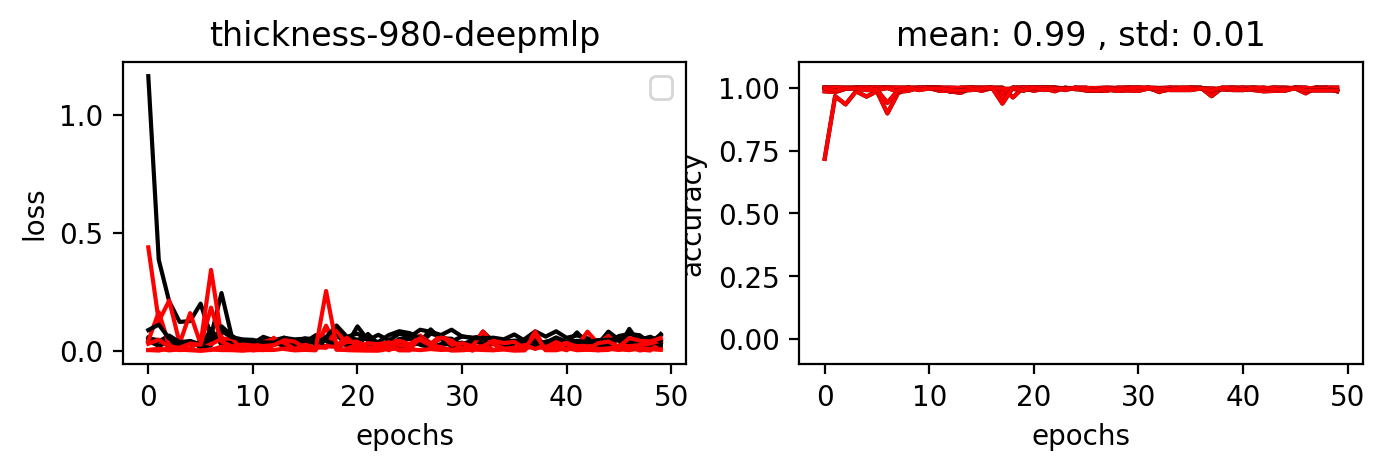

running 5/30 :thickness, 196, baseline
expected values: [0.25 0.25 0.25 0.25] (training)
expected values: [0.25 0.25 0.25 0.25] (test)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 196)               38612     
_________________________________________________________________
dense_26 (Dense)             (None, 98)                19306     
_________________________________________________________________
dense_27 (Dense)             (None, 50)                4950      
_________________________________________________________________
dense_28 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 104       
Total params: 64,247
Trainable params: 64,247
Non-trainable params: 0
_______________________________________________

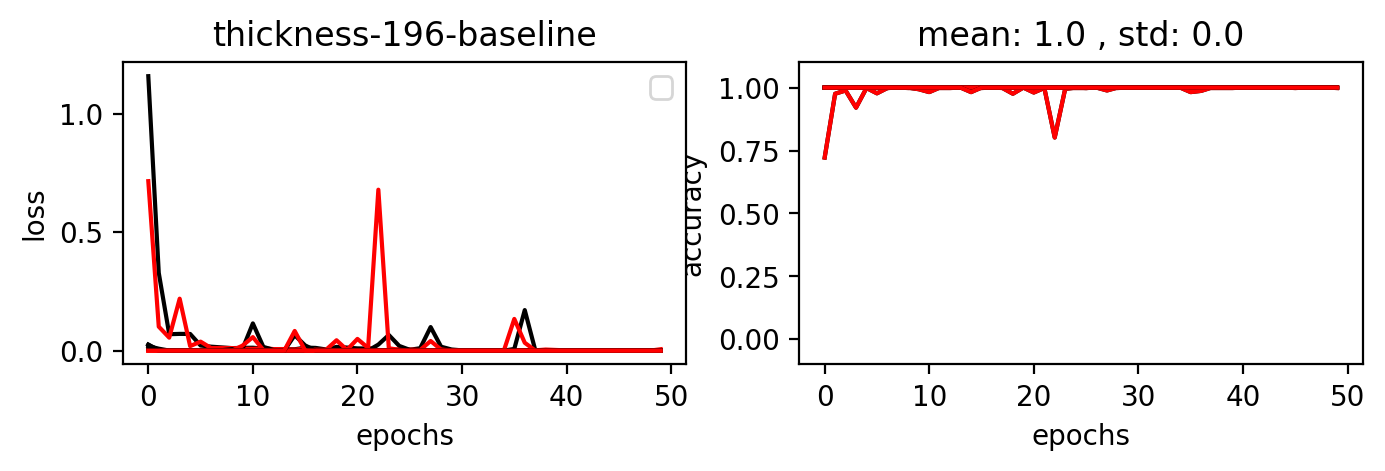

running 6/30 :thickness, 196, deepmlp
expected values: [0.25 0.25 0.25 0.25] (training)
expected values: [0.25 0.25 0.25 0.25] (test)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 196)               38612     
_________________________________________________________________
dropout_11 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 98)                19306     
_________________________________________________________________
dropout_12 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 12)                1188      
_________________________________________________________________
dropout_13 (Dropout)         (None, 12)             

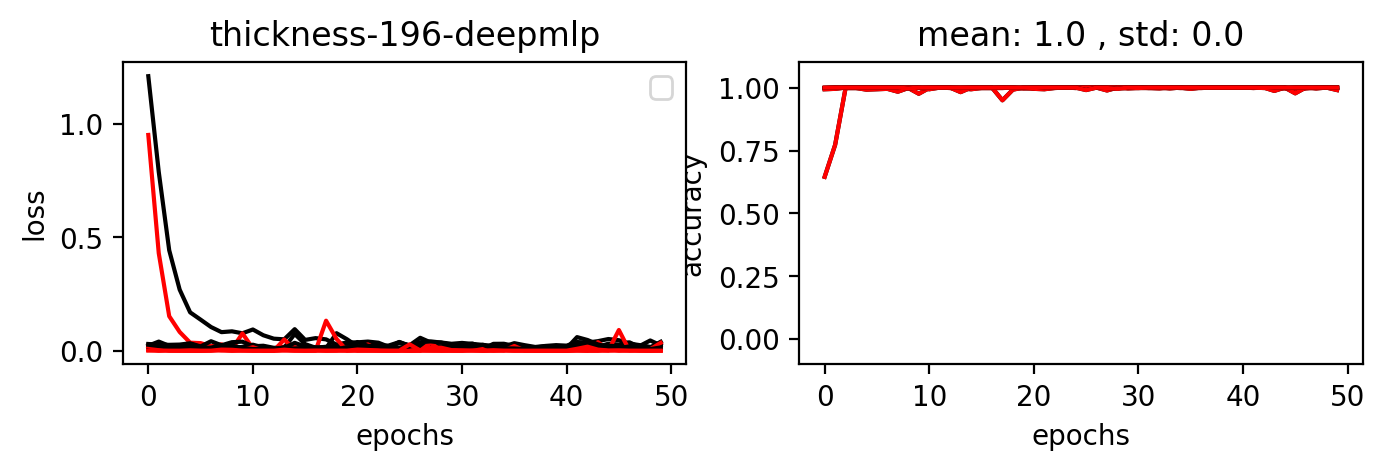

running 7/30 :diameter, 1960, baseline
expected values: [0.33 0.34 0.33] (training)
expected values: [0.33 0.34 0.33] (test)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1960)              3843560   
_________________________________________________________________
dense_36 (Dense)             (None, 980)               1921780   
_________________________________________________________________
dense_37 (Dense)             (None, 50)                49050     
_________________________________________________________________
dense_38 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 78        
Total params: 5,815,743
Trainable params: 5,815,743
Non-trainable params: 0
___________________________________________________

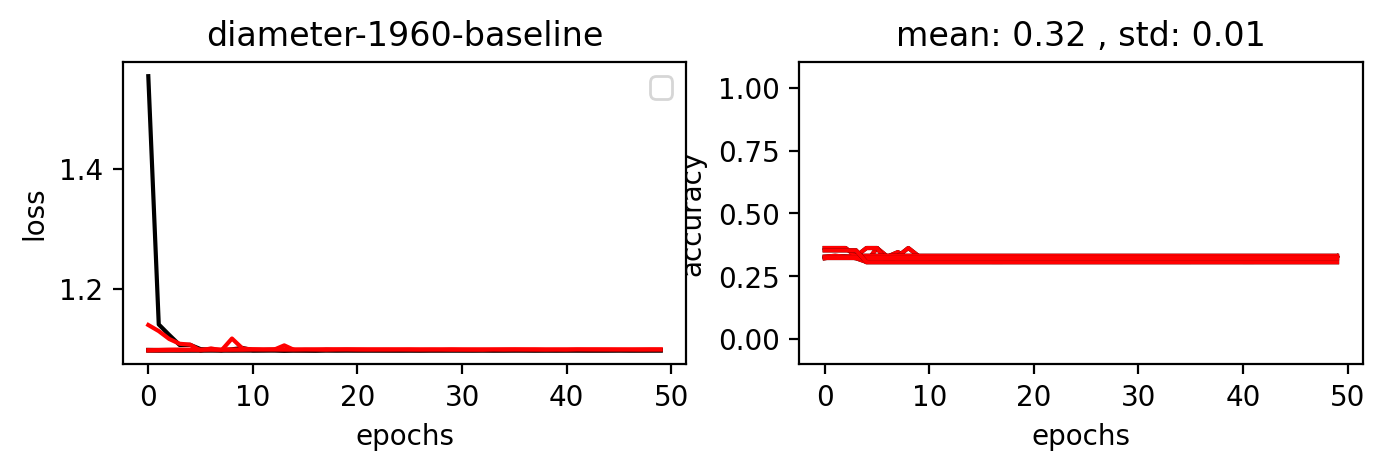

running 8/30 :diameter, 1960, deepmlp
expected values: [0.33 0.34 0.33] (training)
expected values: [0.33 0.34 0.33] (test)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1960)              3843560   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1960)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 980)               1921780   
_________________________________________________________________
dropout_15 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 490)               480690    
_________________________________________________________________
dropout_16 (Dropout)         (None, 490)               0      

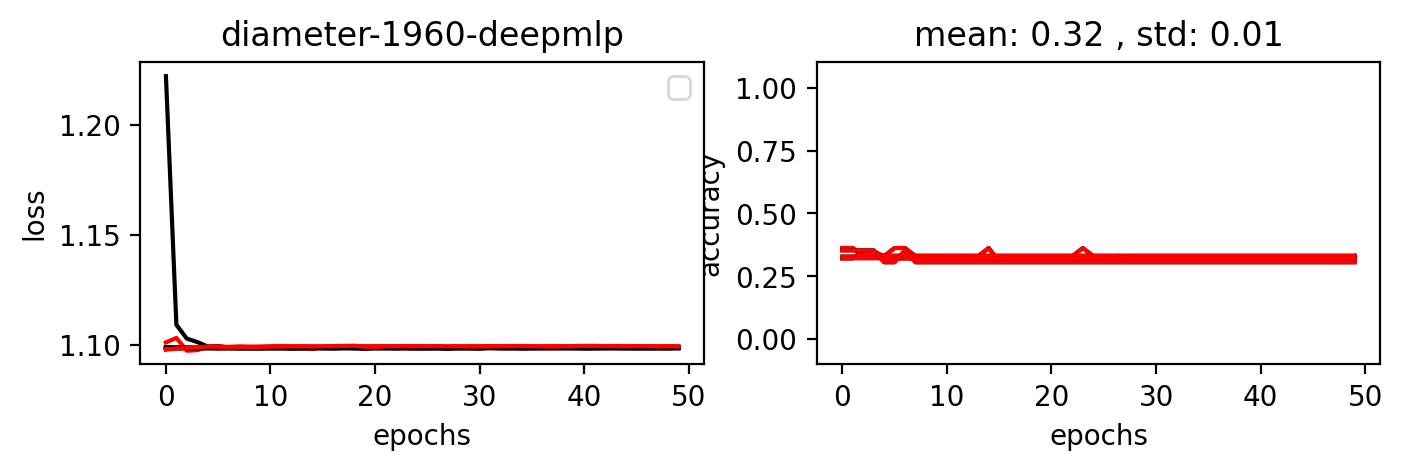

running 9/30 :diameter, 980, baseline
expected values: [0.33 0.34 0.33] (training)
expected values: [0.33 0.34 0.33] (test)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 980)               961380    
_________________________________________________________________
dense_49 (Dense)             (None, 490)               480690    
_________________________________________________________________
dense_50 (Dense)             (None, 50)                24550     
_________________________________________________________________
dense_51 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 78        
Total params: 1,467,973
Trainable params: 1,467,973
Non-trainable params: 0
____________________________________________________

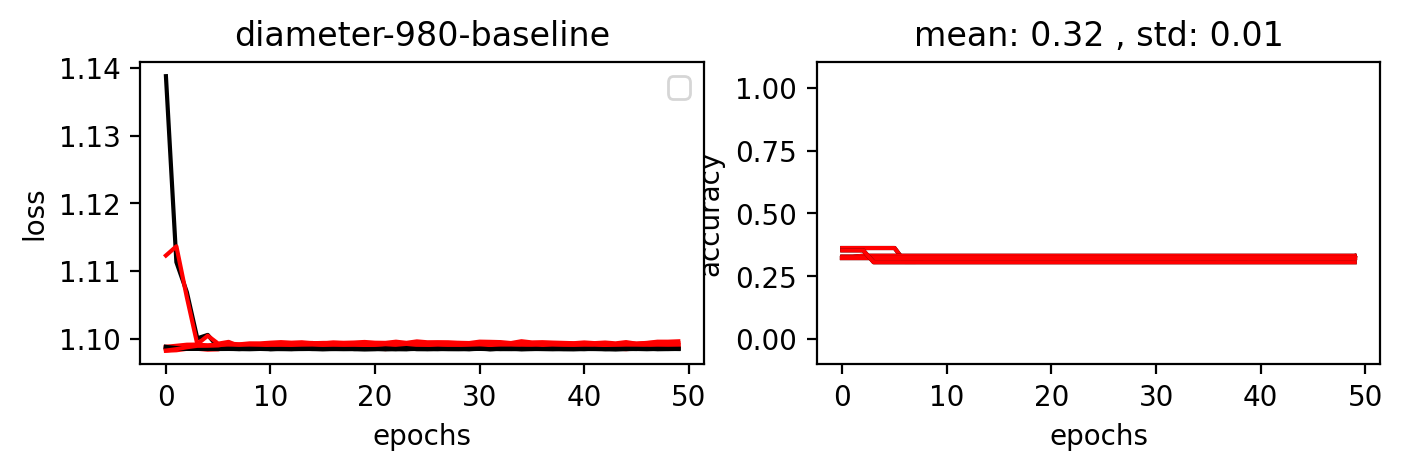

running 10/30 :diameter, 980, deepmlp
expected values: [0.33 0.34 0.33] (training)
expected values: [0.33 0.34 0.33] (test)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 980)               961380    
_________________________________________________________________
dropout_20 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 490)               480690    
_________________________________________________________________
dropout_21 (Dropout)         (None, 490)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 245)               120295    
_________________________________________________________________
dropout_22 (Dropout)         (None, 245)               0      

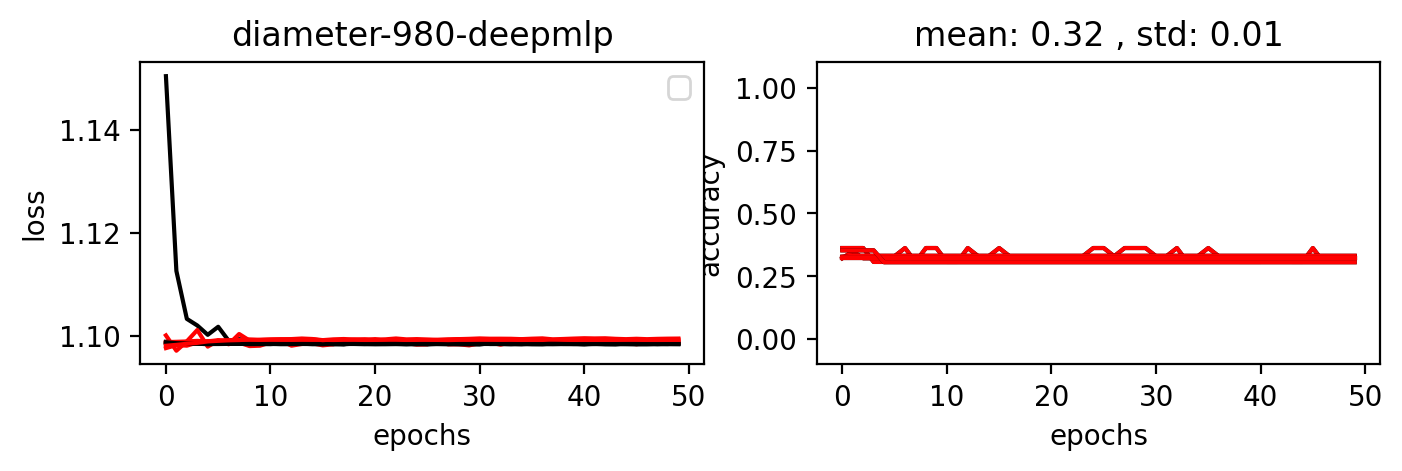

running 11/30 :diameter, 196, baseline
expected values: [0.33 0.34 0.33] (training)
expected values: [0.33 0.34 0.33] (test)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 196)               38612     
_________________________________________________________________
dense_61 (Dense)             (None, 98)                19306     
_________________________________________________________________
dense_62 (Dense)             (None, 50)                4950      
_________________________________________________________________
dense_63 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_64 (Dense)             (None, 3)                 78        
Total params: 64,221
Trainable params: 64,221
Non-trainable params: 0
________________________________________________________

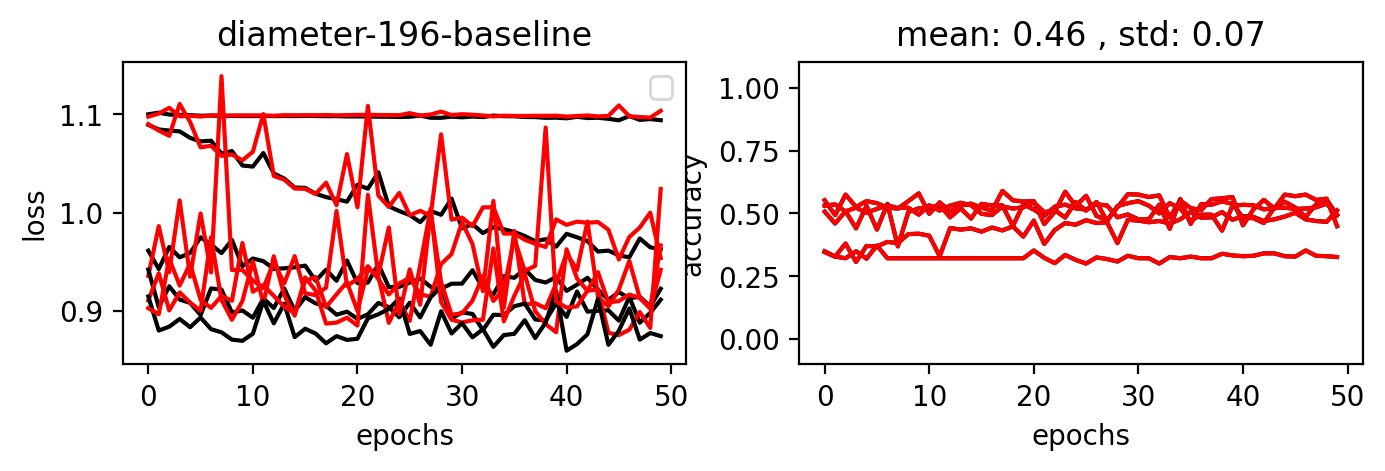

running 12/30 :diameter, 196, deepmlp
expected values: [0.33 0.34 0.33] (training)
expected values: [0.33 0.34 0.33] (test)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 196)               38612     
_________________________________________________________________
dropout_25 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 98)                19306     
_________________________________________________________________
dropout_26 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 12)                1188      
_________________________________________________________________
dropout_27 (Dropout)         (None, 12)                0     

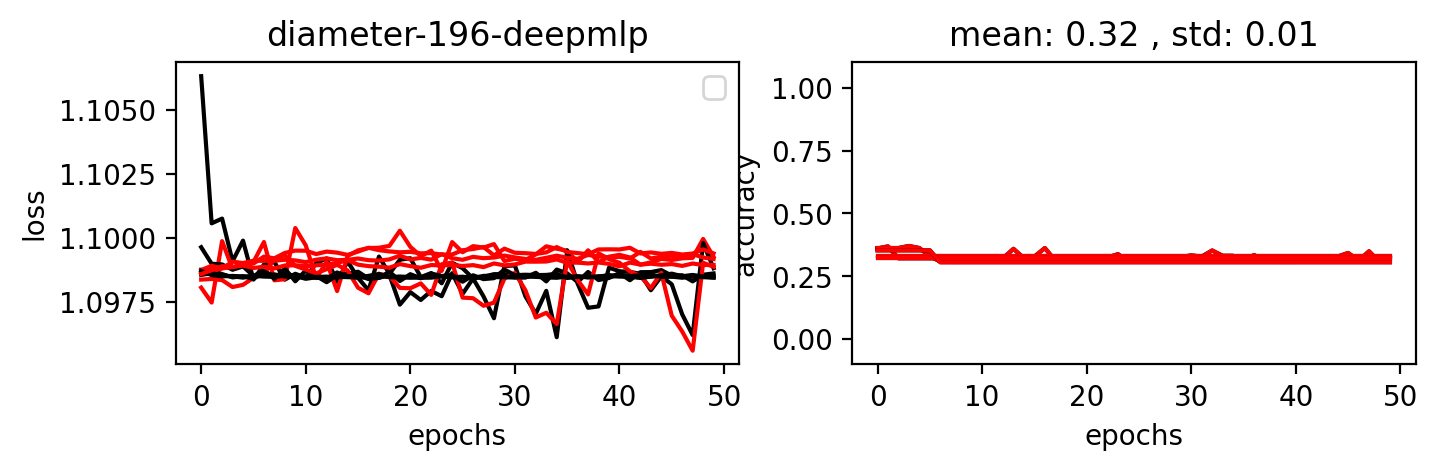

running 13/30 :cutting_tech, 1960, baseline
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (training)
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (test)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 1960)              3843560   
_________________________________________________________________
dense_71 (Dense)             (None, 980)               1921780   
_________________________________________________________________
dense_72 (Dense)             (None, 50)                49050     
_________________________________________________________________
dense_73 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_74 (Dense)             (None, 7)                 182       
Total params: 5,815,847
Trainable params: 5,815,847
Non-trainable params: 0
_____

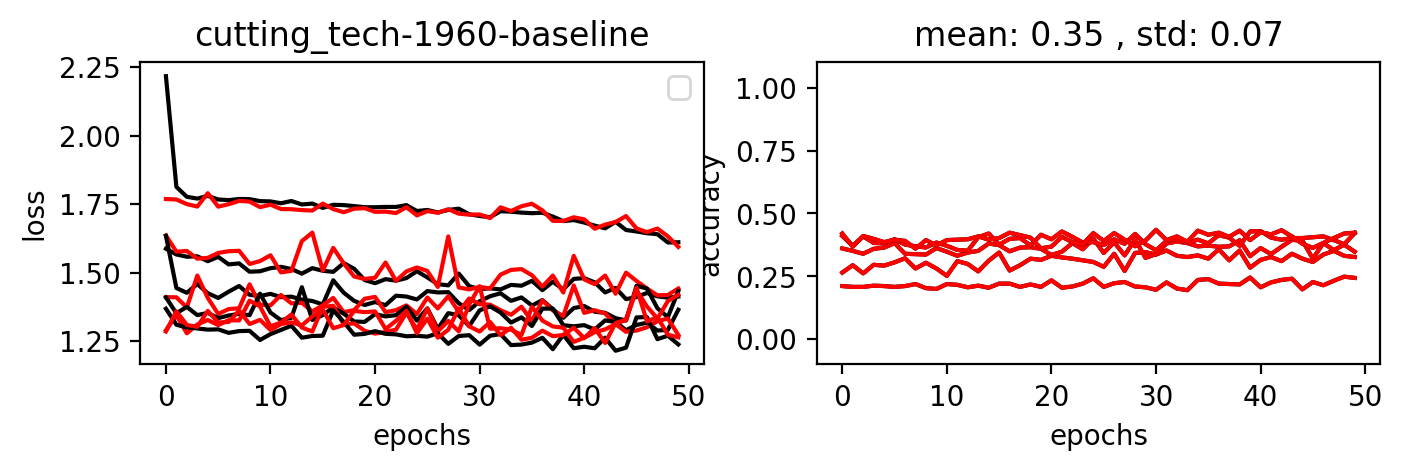

running 14/30 :cutting_tech, 1960, deepmlp
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (training)
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (test)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 1960)              3843560   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1960)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 980)               1921780   
_________________________________________________________________
dropout_29 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 490)               480690    
_________________________________________________________________
dropout_30 (Drop

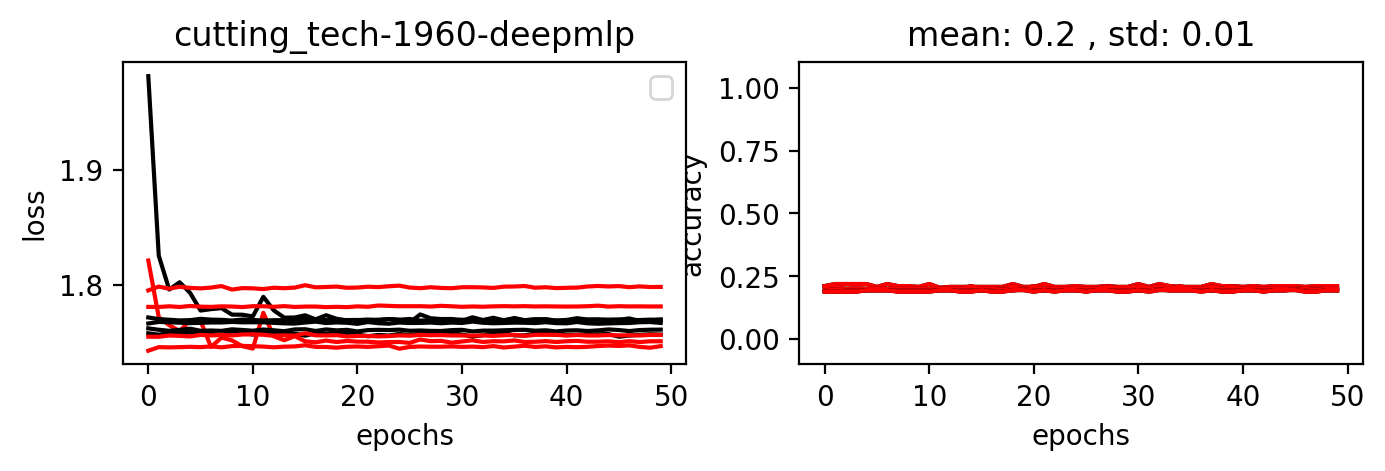

running 15/30 :cutting_tech, 980, baseline
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (training)
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (test)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 980)               961380    
_________________________________________________________________
dense_84 (Dense)             (None, 490)               480690    
_________________________________________________________________
dense_85 (Dense)             (None, 50)                24550     
_________________________________________________________________
dense_86 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_87 (Dense)             (None, 7)                 182       
Total params: 1,468,077
Trainable params: 1,468,077
Non-trainable params: 0
______

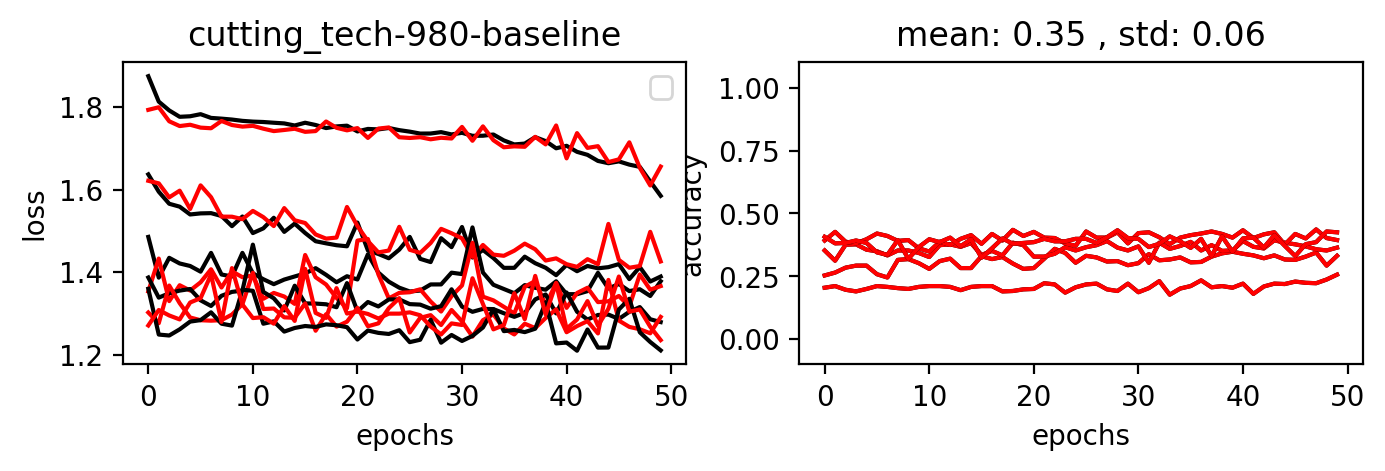

running 16/30 :cutting_tech, 980, deepmlp
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (training)
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (test)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 980)               961380    
_________________________________________________________________
dropout_34 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 490)               480690    
_________________________________________________________________
dropout_35 (Dropout)         (None, 490)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 245)               120295    
_________________________________________________________________
dropout_36 (Dropo

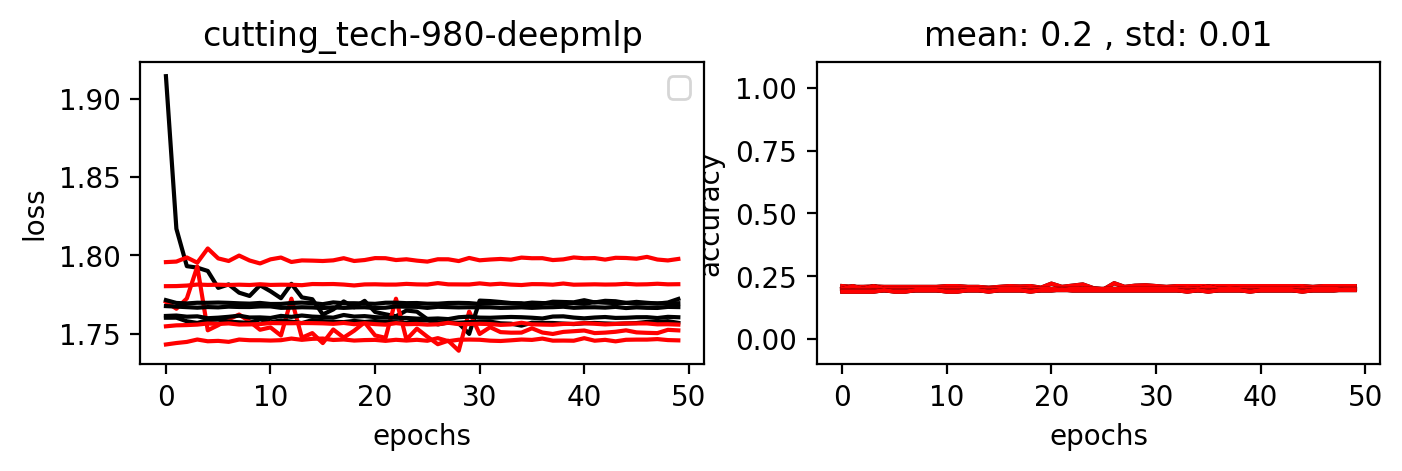

running 17/30 :cutting_tech, 196, baseline
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (training)
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (test)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 196)               38612     
_________________________________________________________________
dense_96 (Dense)             (None, 98)                19306     
_________________________________________________________________
dense_97 (Dense)             (None, 50)                4950      
_________________________________________________________________
dense_98 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_99 (Dense)             (None, 7)                 182       
Total params: 64,325
Trainable params: 64,325
Non-trainable params: 0
____________

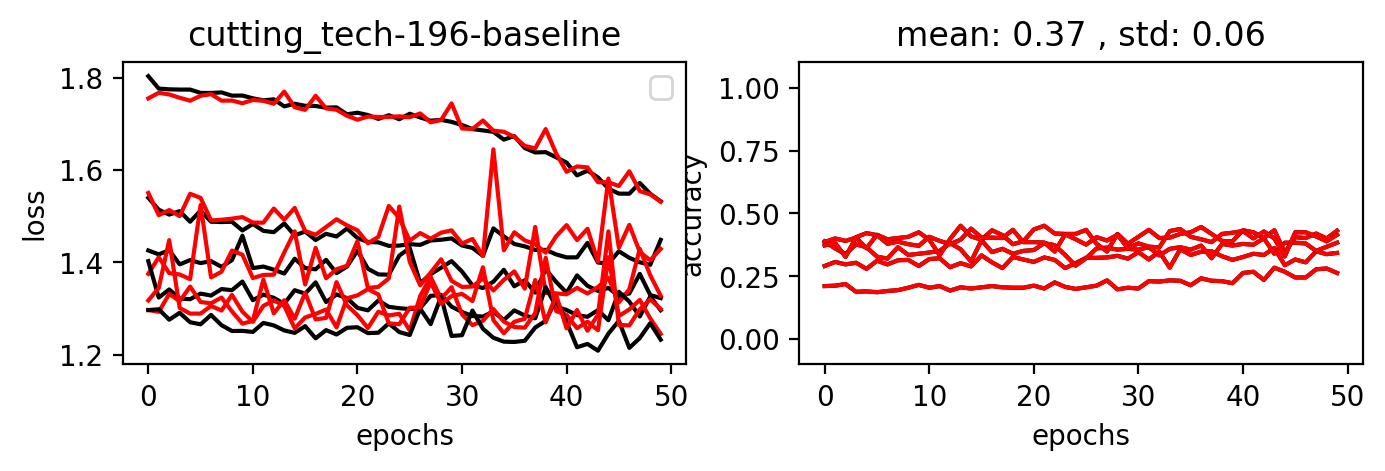

running 18/30 :cutting_tech, 196, deepmlp
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (training)
expected values: [0.07 0.02 0.21 0.21 0.21 0.21 0.07] (test)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 196)               38612     
_________________________________________________________________
dropout_39 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 98)                19306     
_________________________________________________________________
dropout_40 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 12)                1188      
_________________________________________________________________
dropout_41 (Dropo

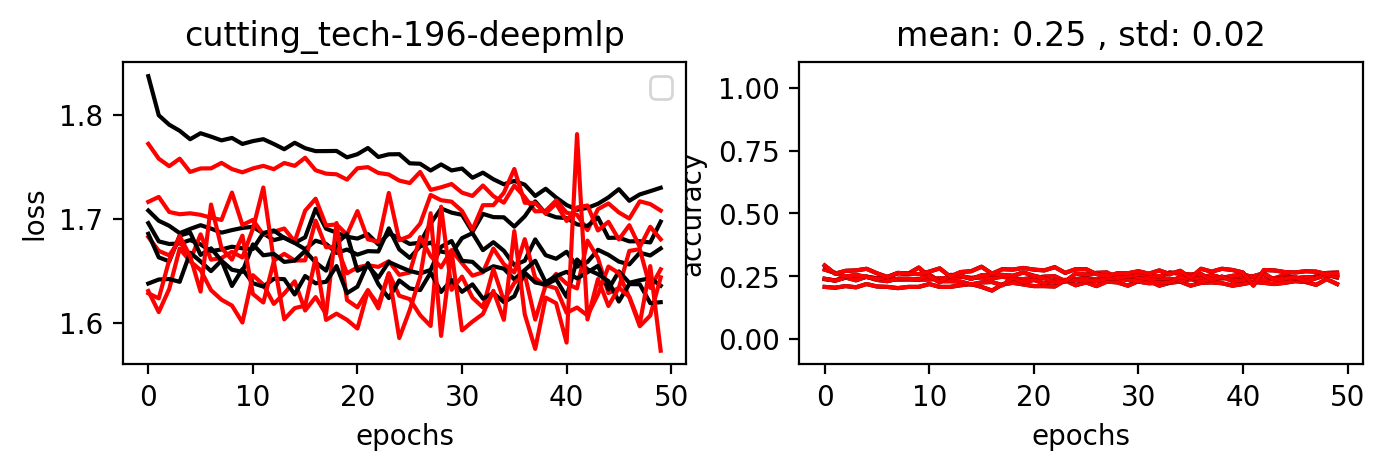

running 19/30 :operator, 1960, baseline
expected values: [0.14 0.3  0.28 0.28] (training)
expected values: [0.14 0.3  0.28 0.28] (test)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 1960)              3843560   
_________________________________________________________________
dense_106 (Dense)            (None, 980)               1921780   
_________________________________________________________________
dense_107 (Dense)            (None, 50)                49050     
_________________________________________________________________
dense_108 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_109 (Dense)            (None, 4)                 104       
Total params: 5,815,769
Trainable params: 5,815,769
Non-trainable params: 0
_______________________________________

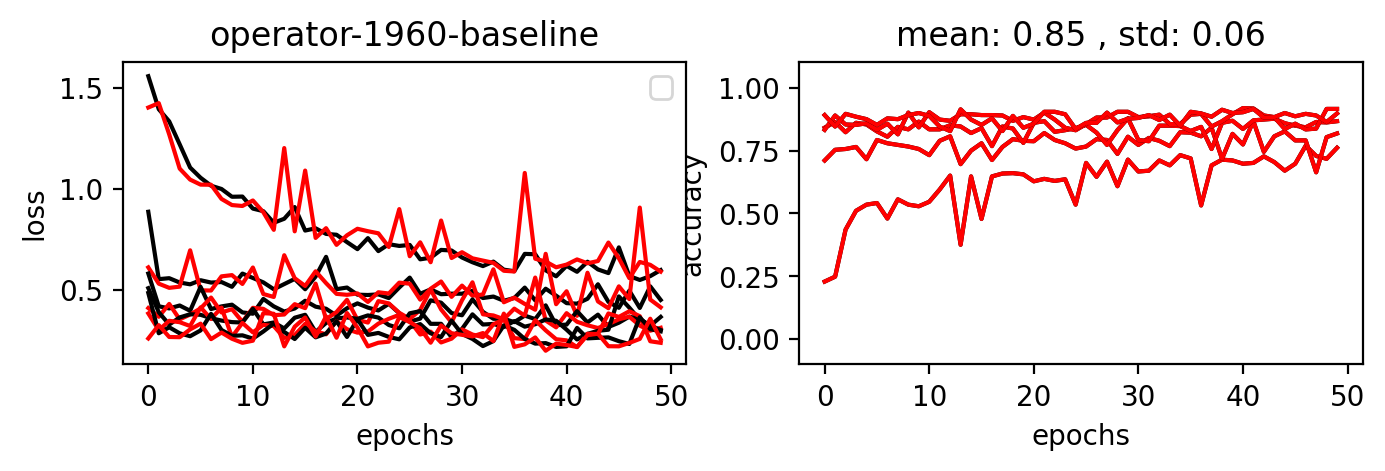

running 20/30 :operator, 1960, deepmlp
expected values: [0.14 0.3  0.28 0.28] (training)
expected values: [0.14 0.3  0.28 0.28] (test)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 1960)              3843560   
_________________________________________________________________
dropout_42 (Dropout)         (None, 1960)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 980)               1921780   
_________________________________________________________________
dropout_43 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 490)               480690    
_________________________________________________________________
dropout_44 (Dropout)         (None, 490)          

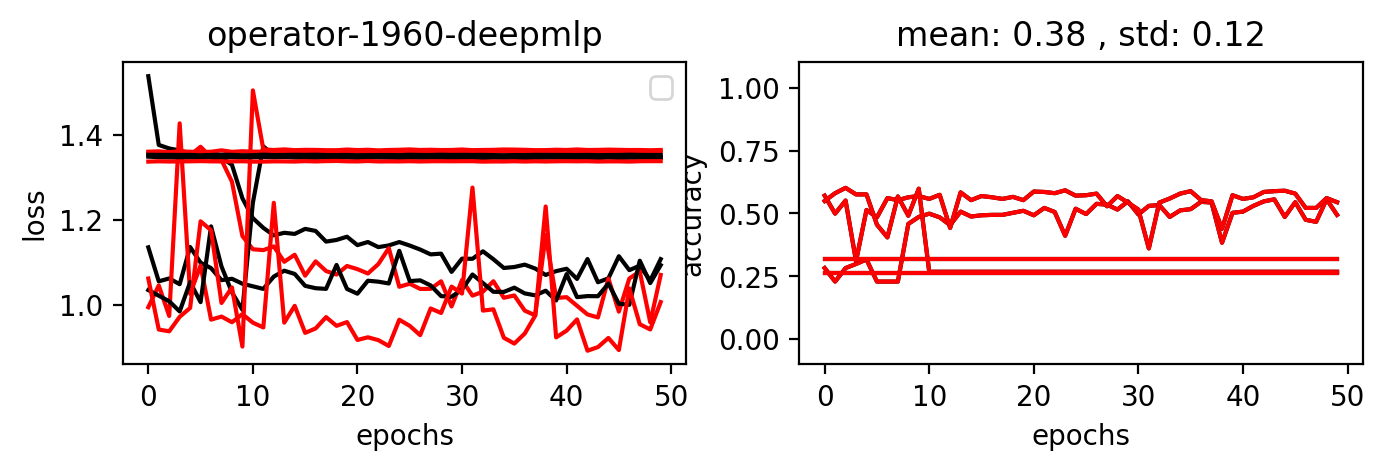

running 21/30 :operator, 980, baseline
expected values: [0.14 0.3  0.28 0.28] (training)
expected values: [0.14 0.3  0.28 0.28] (test)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 980)               961380    
_________________________________________________________________
dense_119 (Dense)            (None, 490)               480690    
_________________________________________________________________
dense_120 (Dense)            (None, 50)                24550     
_________________________________________________________________
dense_121 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_122 (Dense)            (None, 4)                 104       
Total params: 1,467,999
Trainable params: 1,467,999
Non-trainable params: 0
________________________________________

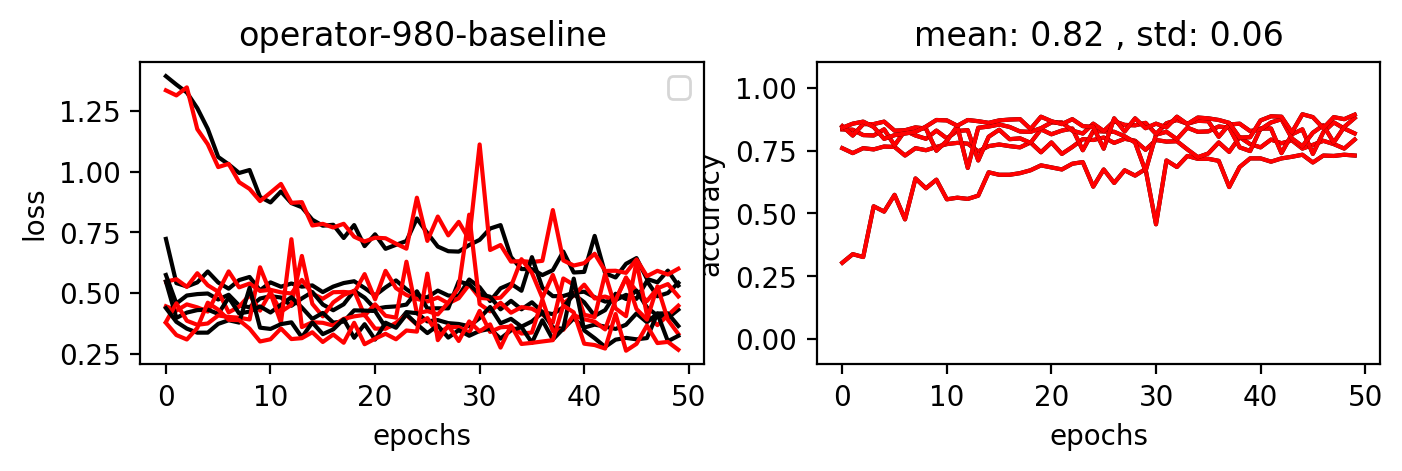

running 22/30 :operator, 980, deepmlp
expected values: [0.14 0.3  0.28 0.28] (training)
expected values: [0.14 0.3  0.28 0.28] (test)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 980)               961380    
_________________________________________________________________
dropout_48 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 490)               480690    
_________________________________________________________________
dropout_49 (Dropout)         (None, 490)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 245)               120295    
_________________________________________________________________
dropout_50 (Dropout)         (None, 245)           

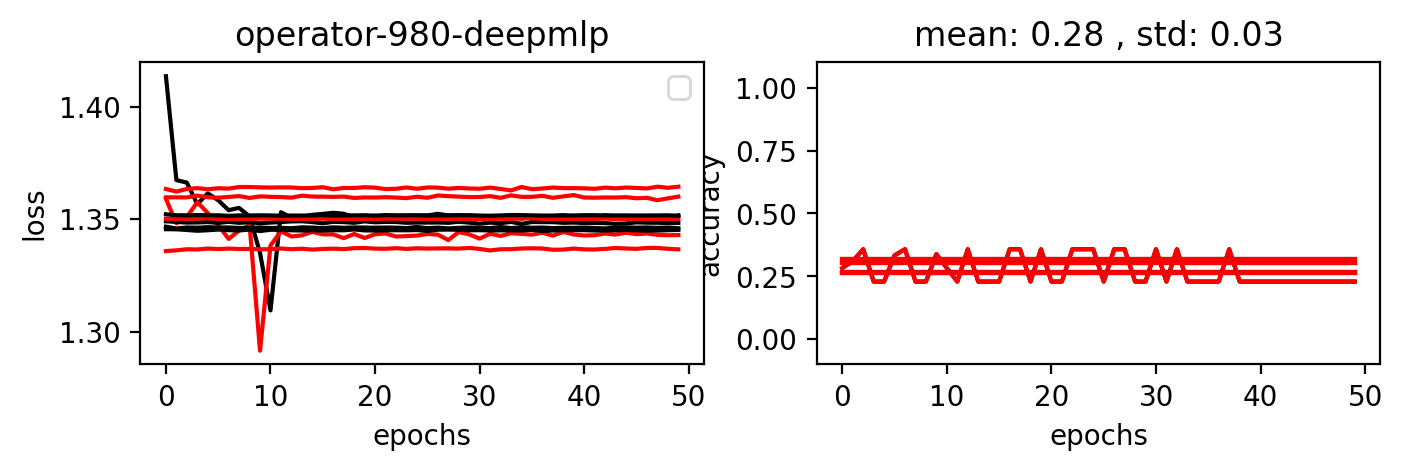

running 23/30 :operator, 196, baseline
expected values: [0.14 0.3  0.28 0.28] (training)
expected values: [0.14 0.3  0.28 0.28] (test)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 196)               38612     
_________________________________________________________________
dense_131 (Dense)            (None, 98)                19306     
_________________________________________________________________
dense_132 (Dense)            (None, 50)                4950      
_________________________________________________________________
dense_133 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_134 (Dense)            (None, 4)                 104       
Total params: 64,247
Trainable params: 64,247
Non-trainable params: 0
______________________________________________

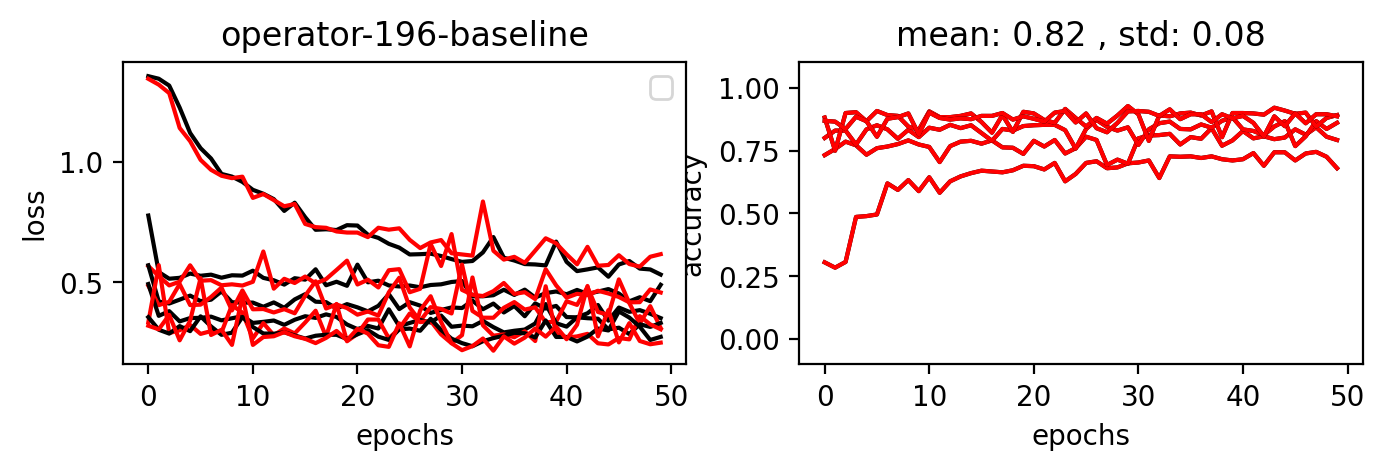

running 24/30 :operator, 196, deepmlp
expected values: [0.14 0.3  0.28 0.28] (training)
expected values: [0.14 0.3  0.28 0.28] (test)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 196)               38612     
_________________________________________________________________
dropout_53 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 98)                19306     
_________________________________________________________________
dropout_54 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 12)                1188      
_________________________________________________________________
dropout_55 (Dropout)         (None, 12)            

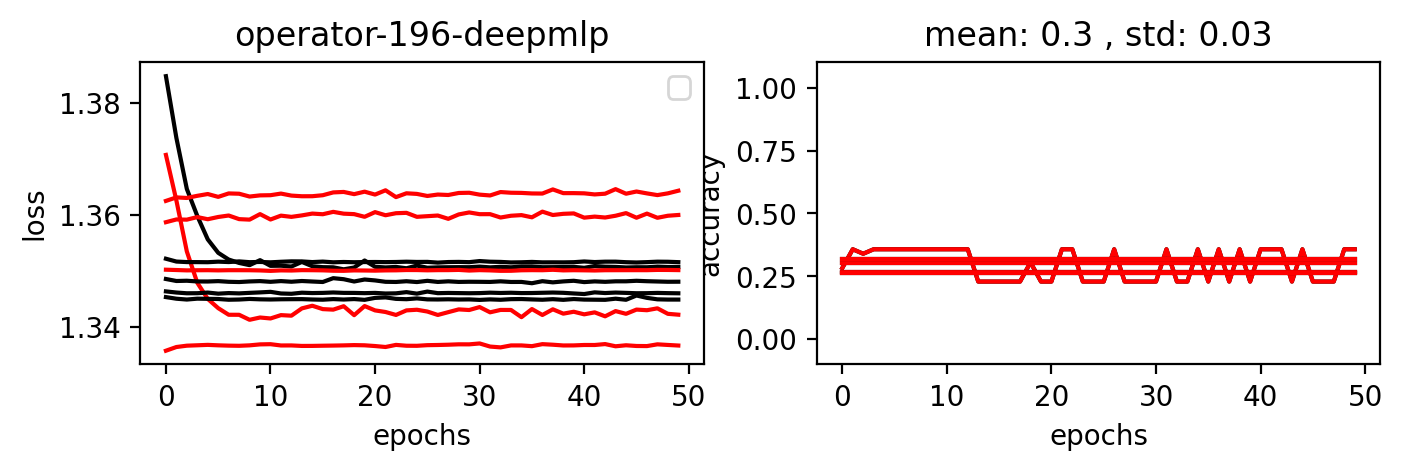

running 25/30 :mounting, 1960, baseline
expected values: [0.5 0.5] (training)
expected values: [0.5 0.5] (test)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 1960)              3843560   
_________________________________________________________________
dense_141 (Dense)            (None, 980)               1921780   
_________________________________________________________________
dense_142 (Dense)            (None, 50)                49050     
_________________________________________________________________
dense_143 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_144 (Dense)            (None, 2)                 52        
Total params: 5,815,717
Trainable params: 5,815,717
Non-trainable params: 0
_______________________________________________________________

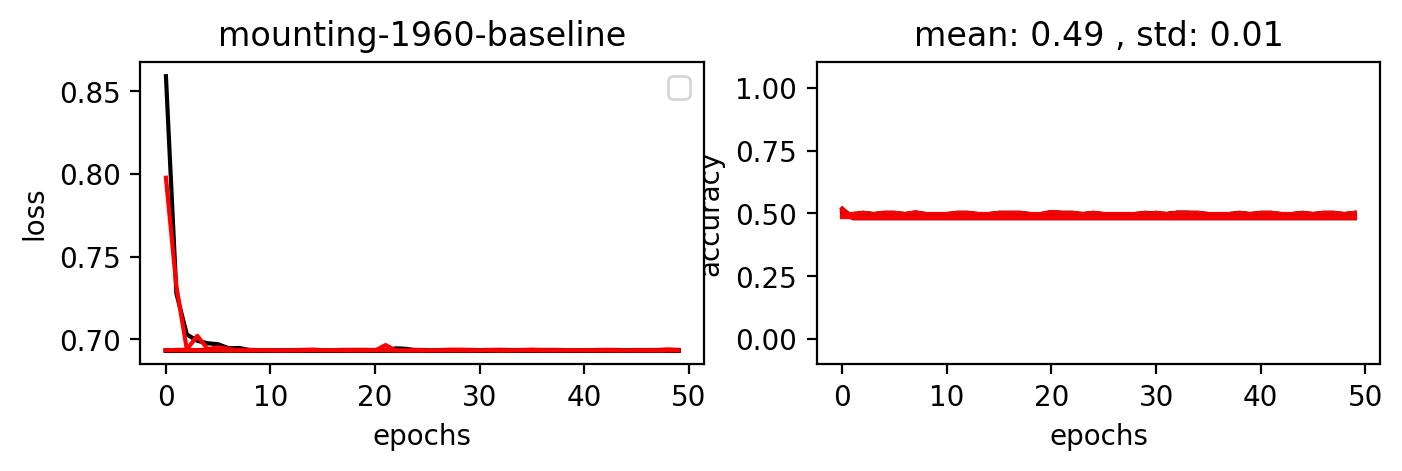

running 26/30 :mounting, 1960, deepmlp
expected values: [0.5 0.5] (training)
expected values: [0.5 0.5] (test)
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 1960)              3843560   
_________________________________________________________________
dropout_56 (Dropout)         (None, 1960)              0         
_________________________________________________________________
dense_146 (Dense)            (None, 980)               1921780   
_________________________________________________________________
dropout_57 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 490)               480690    
_________________________________________________________________
dropout_58 (Dropout)         (None, 490)               0         
________

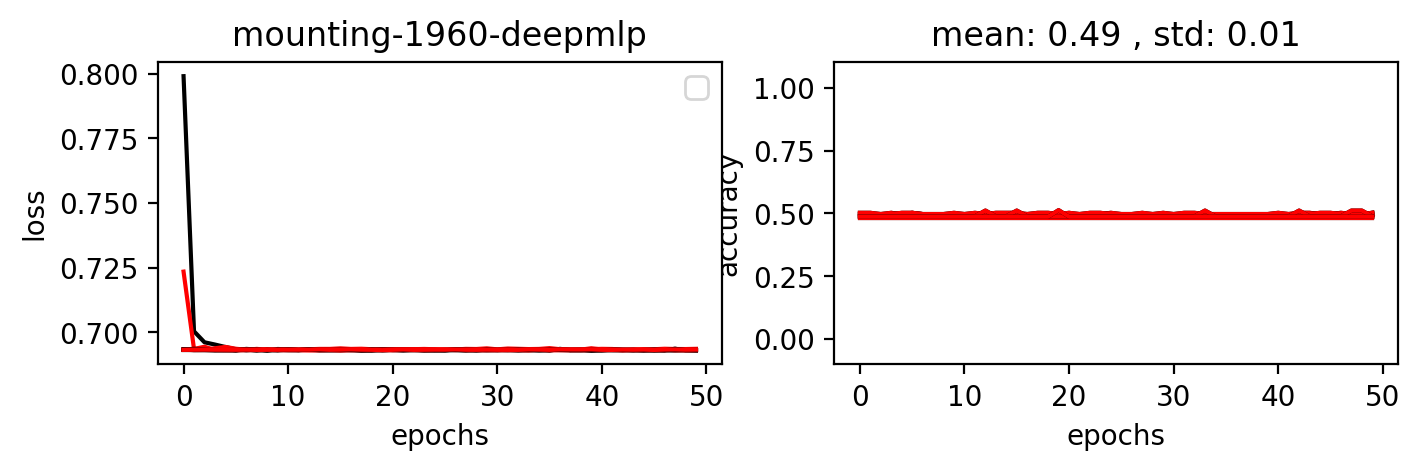

running 27/30 :mounting, 980, baseline
expected values: [0.5 0.5] (training)
expected values: [0.5 0.5] (test)
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 980)               961380    
_________________________________________________________________
dense_154 (Dense)            (None, 490)               480690    
_________________________________________________________________
dense_155 (Dense)            (None, 50)                24550     
_________________________________________________________________
dense_156 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_157 (Dense)            (None, 2)                 52        
Total params: 1,467,947
Trainable params: 1,467,947
Non-trainable params: 0
________________________________________________________________

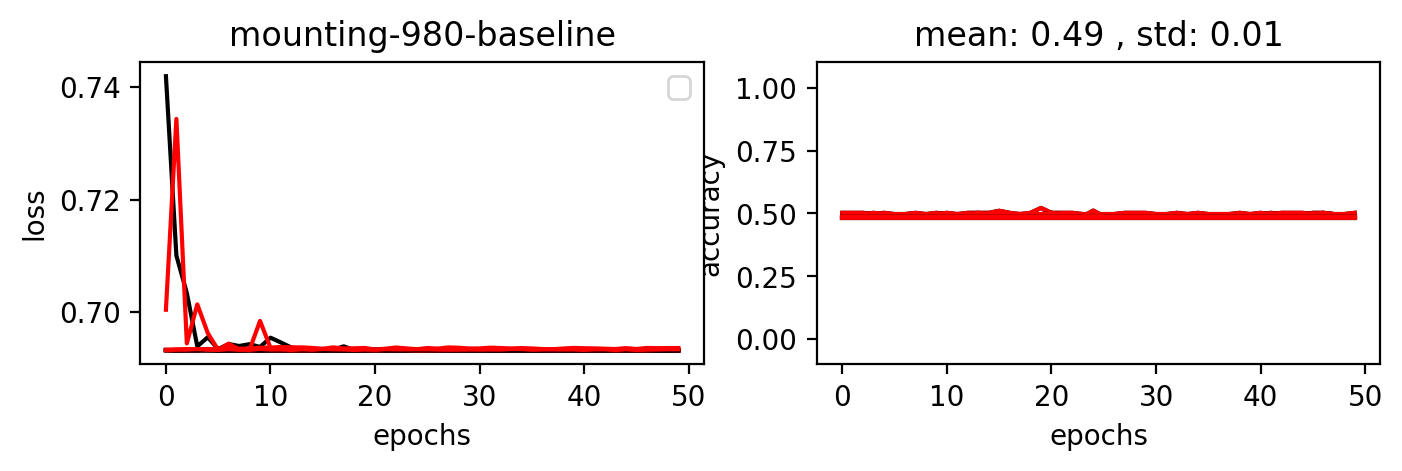

running 28/30 :mounting, 980, deepmlp
expected values: [0.5 0.5] (training)
expected values: [0.5 0.5] (test)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 980)               961380    
_________________________________________________________________
dropout_62 (Dropout)         (None, 980)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 490)               480690    
_________________________________________________________________
dropout_63 (Dropout)         (None, 490)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 245)               120295    
_________________________________________________________________
dropout_64 (Dropout)         (None, 245)               0         
_________

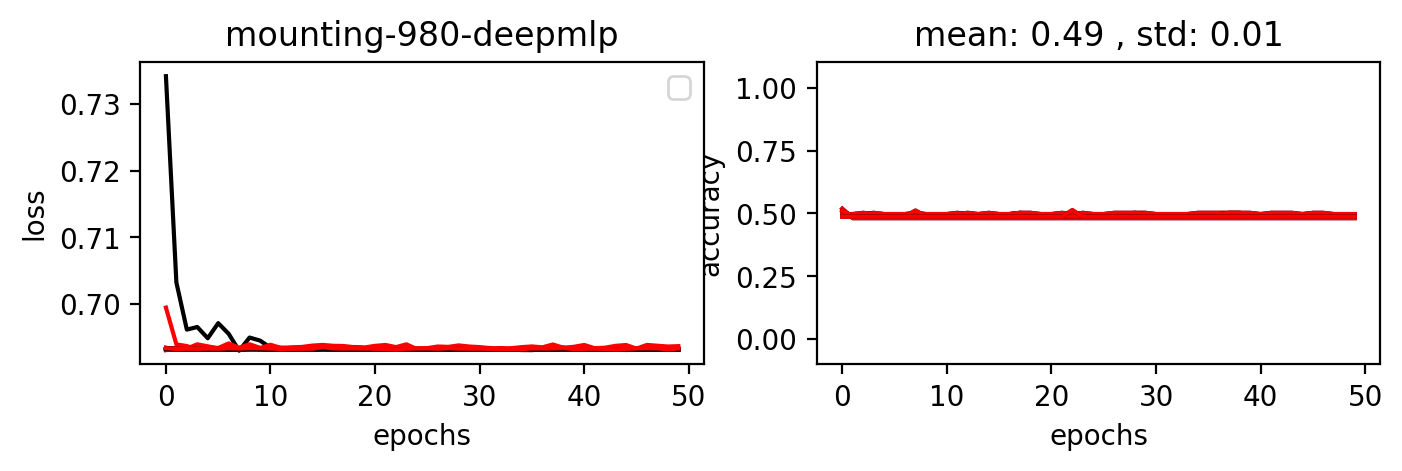

running 29/30 :mounting, 196, baseline
expected values: [0.5 0.5] (training)
expected values: [0.5 0.5] (test)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 196)               38612     
_________________________________________________________________
dense_166 (Dense)            (None, 98)                19306     
_________________________________________________________________
dense_167 (Dense)            (None, 50)                4950      
_________________________________________________________________
dense_168 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_169 (Dense)            (None, 2)                 52        
Total params: 64,195
Trainable params: 64,195
Non-trainable params: 0
_________________________________________________________________
Trai

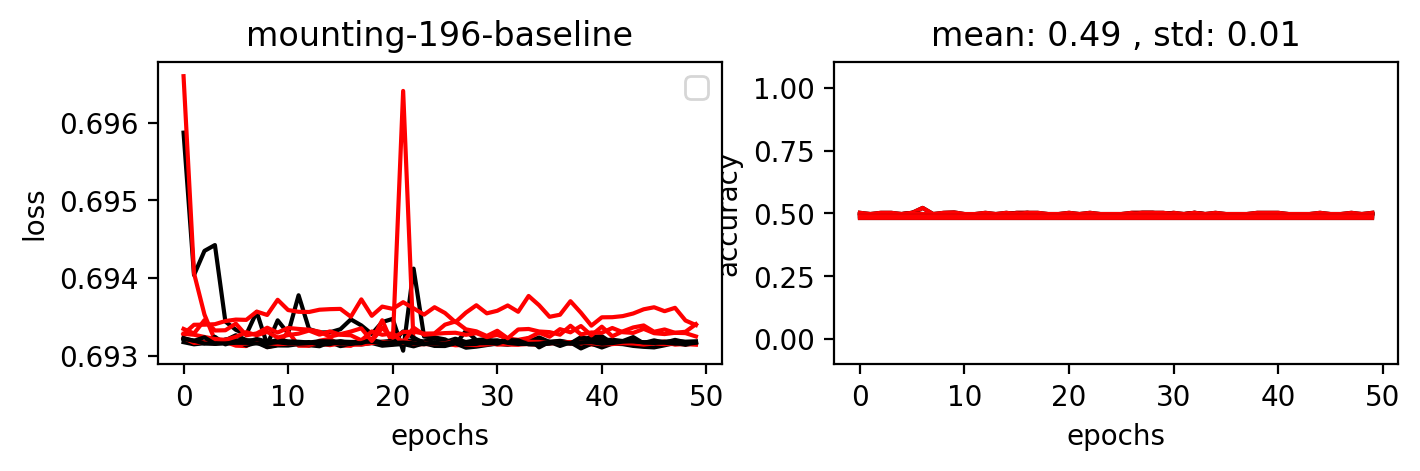

running 30/30 :mounting, 196, deepmlp
expected values: [0.5 0.5] (training)
expected values: [0.5 0.5] (test)
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 196)               38612     
_________________________________________________________________
dropout_67 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 98)                19306     
_________________________________________________________________
dropout_68 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_172 (Dense)            (None, 12)                1188      
_________________________________________________________________
dropout_69 (Dropout)         (None, 12)                0         
_________

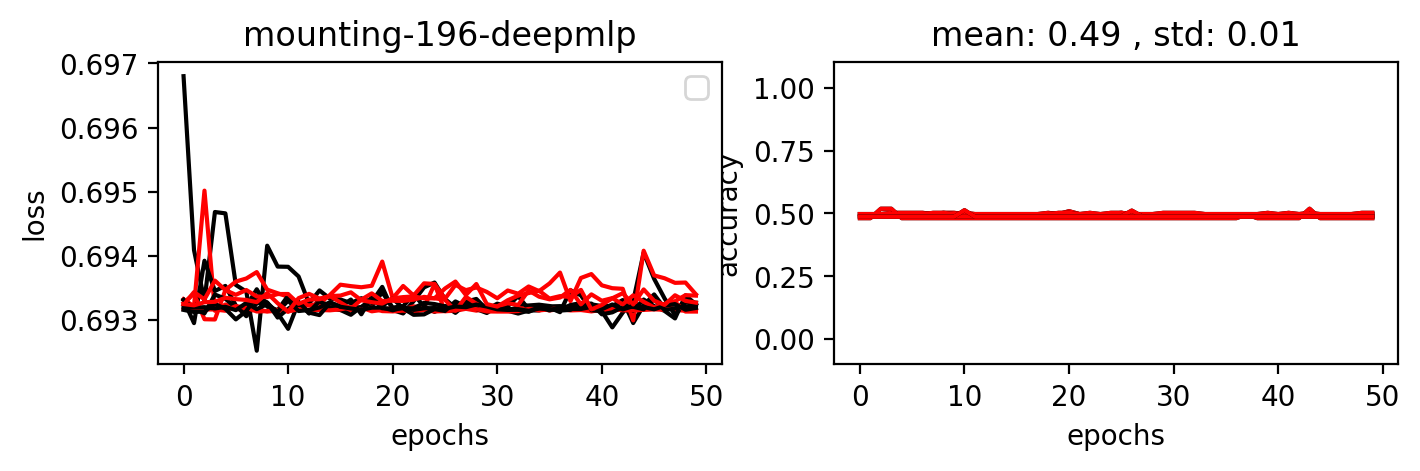

In [3]:
factors = ['thickness', 'diameter', 'cutting_tech', 'operator', 'mounting']
sampl_rates = [1960, 980, 196]
models = ['baseline', 'deepmlp']

K = len(factors)*len(sampl_rates)*len(models)
k = 0

    
# create a directory to store temp. results
cur_path = 'model_selection_results' 
try:
    os.mkdir(cur_path)
except OSError as error:
    print(str(error) + ' already existing')
    shutil.rmtree(cur_path,  ignore_errors=True)
    os.mkdir(cur_path)


# now formulate some nested loops and run the job
for factor_name in factors:
    for n_sampling in sampl_rates:
        for model_name in models: 
            
            k = k+1
            
            # some user feedback
            print('running ' + str(k) + '/' + str(K) + ' :'+ factor_name + ', ' + str(n_sampling) + ', ' + model_name)
            do_univar_modeling(factor_name, n_sampling, model_name)

#### now read all the relevant data entries from the results folders

In [4]:
# now formulate some nested loops and run the job
mean_list = []
std_list = []
f_list = []
s_list = []
m_list = []

for factor_name in factors:
    for n_sampling in sampl_rates:
        for model_name in models: 
            
            # read the pickle file
            sav_str  = factor_name + '-' + str(n_sampling) + '-' + model_name
            data = pickle.load(open('./' + cur_path + '/results-'+sav_str +'.pickle', "rb"))
            
            mean_list.append(np.round(data['mean_acc'],2))
            std_list.append(np.round(data['std_acc'],2))
            f_list.append(factor_name)
            s_list.append(n_sampling)
            m_list.append(model_name)
            
results = pd.DataFrame({'factor':f_list, 'sampling':s_list, 'model':m_list, 'mean':mean_list, 'std':std_list})
results = results.sort_values(['sampling', 'model'])
print(results)

          factor  sampling     model  mean   std
4      thickness       196  baseline  1.00  0.00
10      diameter       196  baseline  0.46  0.07
16  cutting_tech       196  baseline  0.37  0.06
22      operator       196  baseline  0.82  0.08
28      mounting       196  baseline  0.49  0.01
5      thickness       196   deepmlp  1.00  0.00
11      diameter       196   deepmlp  0.32  0.01
17  cutting_tech       196   deepmlp  0.25  0.02
23      operator       196   deepmlp  0.30  0.03
29      mounting       196   deepmlp  0.49  0.01
2      thickness       980  baseline  0.99  0.02
8       diameter       980  baseline  0.32  0.01
14  cutting_tech       980  baseline  0.35  0.06
20      operator       980  baseline  0.82  0.06
26      mounting       980  baseline  0.49  0.01
3      thickness       980   deepmlp  0.99  0.01
9       diameter       980   deepmlp  0.32  0.01
15  cutting_tech       980   deepmlp  0.20  0.01
21      operator       980   deepmlp  0.28  0.03
27      mounting    